In [1]:
# load appropriate modules
import numpy as np
import xarray as xr
from xmitgcm import open_mdsdataset
from matplotlib import pyplot as plt
%matplotlib inline
from xgcm import Grid
from scipy import linalg as lin
from scipy import signal as sig
from scipy import fftpack as fft
from scipy import interpolate as naiso
from matplotlib import colors, ticker, cm
import xrft
#import gsw

In [2]:
def azimuthal_avg(k, l, f, N, nfactor):
    """
    Takes the azimuthal average of a given field.
    """
    k = k.values; l = l.values
    kk, ll = np.meshgrid(k, l)
    K = np.sqrt(kk**2 + ll**2)
    nbins = int(N/nfactor)
    if k.max() > l.max():
        ki = np.linspace(0., l.max(), nbins)
    else:
        ki = np.linspace(0., k.max(), nbins)

    kidx = np.digitize(np.ravel(K), ki)
    area = np.bincount(kidx)

    kr = np.bincount(kidx, weights=K.ravel()) / area

    if f.ndim == 2:
        iso_f = np.ma.masked_invalid(np.bincount(kidx,
                                    weights=f.data.ravel())
                                    / area) * kr
    else:
        raise ValueError('The data has too many or few dimensions. '
                        'The input should only have the two dimensions '
                        'to take the azimuthal averaging over.')

    return kr, iso_f

In [3]:
# Make dictionary
res_time = {"20":{'dt':1200, 'iter1': 5702400, 'iterend':5728320},
            "05":{'dt':300, 'iter1':10368000, 'iterend':10471680}, 
            "01":{'dt':40 , 'iter1':1166400, 'iterend':1944000}}

for keys in res_time.keys():
    res_time[keys]['dirname']='/swot/SUM05/dbalwada/channel_beta/{0}km/tracer_exp1/'.format(keys)

In [4]:

res_time['20']['dt_out'] = 18
res_time['05']['dt_out'] = 72
res_time['01']['dt_out'] = 21600
    

In [5]:
# Load data (for the calc of vertical flux spectra in space)
for keys in res_time.keys():
    
    npick = 40 # pick up every npick'th file as the original out is very dense (12 hours)
    
    dt_out = int(res_time[keys]['dt_out'])
    T1 = int(res_time[keys]['iter1'])
    T2 = int(res_time[keys]['iterend'])
    T340days = int(T1 + (T2-T1)*34/36)
    
    if keys == '01':
        npick=1
        T340days = T2 
    
    iters = range(T1, T340days, dt_out*npick)
    
    ds = open_mdsdataset(res_time[keys]['dirname'],  iters=iters, 
                             delta_t=res_time[keys]['dt'], prefix=['W','PTRACER01']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_main']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm-0.2.1-py3.5.egg/xmitgcm/mds_store.py:235: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [6]:
# Load data
for keys in res_time.keys():
    ds = open_mdsdataset(res_time[keys]['dirname'],  
                             delta_t=res_time[keys]['dt'], prefix=['wVeltave','vVeltave','Ttave']
                     ,ignore_unknown_vars=True, geometry='cartesian')
    res_time[keys]['data_mean']=ds

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm/utils.py:314: UserWarning: Not sure what to do with rlev = L
  warnings.warn("Not sure what to do with rlev = " + rlev)
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xmitgcm/mds_store.py:220: FutureWarning: iteration over an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Iterate over the Dataset.variables property instead to preserve existing behavior in a forwards compatible manner.
  for vname in ds:


In [6]:
# Mixing layer depth calculated in other codes.

Hmix_perc = {'01': 144.28248626708978, '05': 198.28811721801759, '20': 271.59768463134759}

In [7]:
ylevs = [600e3,1400e3]
zlevs = [0., -700.]
tlevs = [4,18]
res = sorted(res_time)
label = {"20":"20 km", "01":"1 km", 
            "05":"5 km"}

In [8]:
# Cross spectrum of vertical fluxes for Upstream region 
xlevs = [0,800e3]
WCcs_us = {}
Wps_us  = {}
Cps_us  = {}
Coh_us  = {}
Wdata_us = {}
Cdata_us = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    W_us = res_time[key]['data_main'].W #- res_time[key]['data_mean'].wVeltave.mean('time')
    W_us = W_us.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))

    Wint_us = grid.interp(W_us, 'Z', boundary='extend')
    Wint_us = Wint_us.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1]))
    Wint_us = Wint_us.chunk(chunks={'time':len(Wint_us.time), 'XC':len(Wint_us.XC),  'YC':len(Wint_us.YC), 'Z':2})
    
    Wdata_us[key] = Wint_us
    Wdata_us[key].load()
    
    C_us  = res_time[key]['data_main']['PTRACER01']# - res_time[key]['data_mean'].Ttave.mean('time')
    C_us  = C_us.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])
                    ).sel(Z = slice(zlevs[0], zlevs[1]) ).isel(time=slice(tlevs[0],tlevs[1]))
    C_us  = C_us.chunk(chunks={'time':len(C_us.time),  'XC':len(C_us.XC), 'YC':len(C_us.YC), 'Z':2})
    
    Cdata_us[key] = C_us
    Cdata_us[key].load()
    
    Wps_us[key]  = xrft.power_spectrum(Wdata_us[key], dim=['XC','YC'], window='hanning')
    Cps_us[key]  = xrft.power_spectrum(Cdata_us[key], dim=['XC','YC'], window='hanning')    

    WCcs_us[key] = xrft.cross_spectrum(Wdata_us[key], Cdata_us[key], dim =['XC', 'YC'], window='hanning')
    
#    Coh[key]  = WCcs[key]/(Wps[key]**0.5)/(Cps[key]**0.5)

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [ ]:
# Cross spectrum of horizontal fluxes  for Upstream region 
xlevs = [0,800e3]
UCcs_us = {}
Ups_us  = {}
VCcs_us = {}
Vps_us  = {}

Udata_us = {}
Vdata_us = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    U_us = res_time[key]['data_main'].U #- res_time[key]['data_mean'].wVeltave.mean('time')
#    U_us = U_us.sel(YC = slice(ylevs[0], ylevs[1]), XG = slice(xlevs[0], xlevs[1]))

    Uint_us = grid.interp(U_us, 'X')
    Uint_us = Uint_us.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1])
                        ).sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    
    Uint_us = Uint_us.chunk(chunks={'time':len(Uint_us.time),
                                    'XC':len(Uint_us.XC),  'YC':len(Uint_us.YC), 'Z':2})
    
    Udata_us[key] = Uint_us
    Udata_us[key].load()

    V_us = res_time[key]['data_main'].V #- res_time[key]['data_mean'].wVeltave.mean('time')
    #V_us = V_us.sel(YG = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))

    Vint_us = grid.interp(V_us, 'Y',boundary='extend')
    Vint_us = Vint_us.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1])
                        ).sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    
    Vint_us = Vint_us.chunk(chunks={'time':len(Vint_us.time),
                                    'XC':len(Vint_us.XC),  'YC':len(Vint_us.YC), 'Z':2})
    
    Vdata_us[key] = Vint_us
    Vdata_us[key].load()    

    
    Ups_us[key]  = xrft.power_spectrum(Udata_us[key], dim=['XC','YC'], window='hanning')
    Vps_us[key]  = xrft.power_spectrum(Vdata_us[key], dim=['XC','YC'], window='hanning')    

    UCcs_us[key] = xrft.cross_spectrum(Udata_us[key], Cdata_us[key],
                                       dim =['XC', 'YC'], window='hanning')
    VCcs_us[key] = xrft.cross_spectrum(Vdata_us[key], Cdata_us[key],
                                       dim =['XC', 'YC'], window='hanning')    
    
#    Coh[key]  = WCcs[key]/(Wps[key]**0.5)/(Cps[key]**0.5)

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [9]:
# Cross spectrum of vertical fluxes for down stream region 
xlevs = [1000,1800e3]

WCcs_ds = {}
Wps_ds  = {}
Cps_ds  = {}
Coh_ds  = {}
Wdata_ds = {}
Cdata_ds = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    W_ds = res_time[key]['data_main'].W #- res_time[key]['data_mean'].wVeltave.mean('time')
    W_ds = W_ds.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))

    Wint_ds = grid.interp(W_ds, 'Z', boundary='extend')
    Wint_ds = Wint_ds.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1]))
    Wint_ds = Wint_ds.chunk(chunks={'time':len(Wint_ds.time), 'XC':len(Wint_ds.XC),  'YC':len(Wint_ds.YC), 'Z':2})
    
    Wdata_ds[key] = Wint_ds
    Wdata_ds[key].load()
    
    C_ds  = res_time[key]['data_main']['PTRACER01']# - res_time[key]['data_mean'].Ttave.mean('time')
    C_ds  = C_ds.sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1])
                    ).sel(Z = slice(zlevs[0], zlevs[1]) ).isel(time=slice(tlevs[0],tlevs[1]))
    C_ds  = C_ds.chunk(chunks={'time':len(C_ds.time),  'XC':len(C_ds.XC), 'YC':len(C_ds.YC), 'Z':2})
    
    Cdata_ds[key] = C_ds
    Cdata_ds[key].load()
    
    Wps_ds[key]  = xrft.power_spectrum(Wdata_ds[key], dim=['XC','YC'], window='hanning')
    Cps_ds[key]  = xrft.power_spectrum(Cdata_ds[key], dim=['XC','YC'], window='hanning')    

    WCcs_ds[key] = xrft.cross_spectrum(Wdata_ds[key], Cdata_ds[key], dim =['XC', 'YC'], window='hanning')
    
#    Coh[key]  = WCcs[key]/(Wps[key]**0.5)/(Cps[key]**0.5)

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [ ]:
# Cross spectrum of horizontal fluxes for downstream region 
xlevs = [800,1600e3]
UCcs_ds = {}
Ups_ds  = {}
VCcs_ds = {}
Vps_ds  = {}

Udata_ds = {}
Vdata_ds = {}

for key in res:
    print(key)
    grid = Grid(res_time[key]['data_main'], periodic='XC')

    U_ds = res_time[key]['data_main'].U #- res_time[key]['data_mean'].wVeltave.mean('time')
#    U_us = U_us.sel(YC = slice(ylevs[0], ylevs[1]), XG = slice(xlevs[0], xlevs[1]))

    Uint_ds = grid.interp(U_ds, 'X')
    Uint_ds = Uint_ds.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1])
                        ).sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    
    Uint_ds = Uint_ds.chunk(chunks={'time':len(Uint_ds.time),
                                    'XC':len(Uint_ds.XC),  'YC':len(Uint_ds.YC), 'Z':2})
    
    Udata_ds[key] = Uint_ds
    Udata_ds[key].load()

    V_ds = res_time[key]['data_main'].V #- res_time[key]['data_mean'].wVeltave.mean('time')
    #V_us = V_us.sel(YG = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))

    Vint_ds = grid.interp(V_ds, 'Y',boundary='extend')
    Vint_ds = Vint_ds.sel(Z = slice(zlevs[0], zlevs[1])).isel(time=slice(tlevs[0],tlevs[1])
                        ).sel(YC = slice(ylevs[0], ylevs[1]), XC = slice(xlevs[0], xlevs[1]))
    
    Vint_ds = Vint_ds.chunk(chunks={'time':len(Vint_ds.time),
                                    'XC':len(Vint_ds.XC),  'YC':len(Vint_ds.YC), 'Z':2})
    
    Vdata_ds[key] = Vint_ds
    Vdata_ds[key].load()    

    
    Ups_ds[key]  = xrft.power_spectrum(Udata_ds[key], dim=['XC','YC'], window='hanning')
    Vps_ds[key]  = xrft.power_spectrum(Vdata_ds[key], dim=['XC','YC'], window='hanning')    

    UCcs_ds[key] = xrft.cross_spectrum(Udata_ds[key], Cdata_ds[key],
                                       dim =['XC', 'YC'], window='hanning')
    VCcs_ds[key] = xrft.cross_spectrum(Vdata_ds[key], Cdata_ds[key],
                                       dim =['XC', 'YC'], window='hanning')    
    
#    Coh[key]  = WCcs[key]/(Wps[key]**0.5)/(Cps[key]**0.5)

01


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/xrft-0.1-py3.5.egg/xrft/xrft.py:272: FutureWarning: xarray.DataArray.__contains__ currently checks membership in DataArray.coords, but in xarray v0.11 will change to check membership in array values.


05
20


In [10]:
# time average and load the vertical flux spectra 
WCcs_us_mean = {}
Wps_us_mean  = {}
Cps_us_mean  = {}

WCcs_ds_mean = {}
Wps_ds_mean  = {}
Cps_ds_mean  = {}

for key in res:
    Wps_us_mean[key] = Wps_us[key].mean('time')
    Cps_us_mean[key] = Cps_us[key].mean('time')
    WCcs_us_mean[key] = WCcs_us[key].mean('time')
    
    Wps_us_mean[key].load()
    Cps_us_mean[key].load()
    WCcs_us_mean[key].load()
    
    Wps_ds_mean[key] = Wps_ds[key].mean('time')
    Cps_ds_mean[key] = Cps_ds[key].mean('time')
    WCcs_ds_mean[key] = WCcs_ds[key].mean('time')
    
    Wps_ds_mean[key].load()
    Cps_ds_mean[key].load()
    WCcs_ds_mean[key].load()

In [ ]:
# time average and load the horizontal flux spectra 

UCcs_us_mean = {}
VCcs_us_mean = {}
Ups_us_mean  = {}
Vps_us_mean  = {}

UCcs_ds_mean = {}
VCcs_ds_mean = {}
Ups_ds_mean  = {}
Vps_ds_mean  = {}

for key in res:
    Ups_us_mean[key]  = Ups_us[key].mean('time')
    Vps_us_mean[key]  = Vps_us[key].mean('time')
    UCcs_us_mean[key] = UCcs_us[key].mean('time')
    VCcs_us_mean[key] = VCcs_us[key].mean('time')
    
    Ups_us_mean[key].load()
    Vps_us_mean[key].load()
    UCcs_us_mean[key].load()
    VCcs_us_mean[key].load()
    
    Ups_ds_mean[key]  = Ups_ds[key].mean('time')
    Vps_ds_mean[key]  = Vps_ds[key].mean('time')
    UCcs_ds_mean[key] = UCcs_ds[key].mean('time')
    VCcs_ds_mean[key] = VCcs_ds[key].mean('time')
    
    Ups_ds_mean[key].load()
    Vps_ds_mean[key].load()
    UCcs_ds_mean[key].load()
    VCcs_ds_mean[key].load()
    

In [11]:
def iso_spec_over_depth(ds):
    
    Zlen = len(ds.Z)
    klen = len(ds.freq_XC)
    nfactor = 4. 
    ds_iso = np.zeros([Zlen, int(klen/nfactor+1)])

    for i in range(0,Zlen):
        kr, ds_iso[i,:] = azimuthal_avg(ds.freq_XC, ds.freq_YC, ds.isel(Z=i), 
                            len(ds.freq_XC), nfactor)
    kr[0] = 0.
    ds_iso_xr = xr.DataArray(ds_iso, coords={'Z': ds.Z.values, 'kr':kr }, dims=['Z', 'kr'])
    
    return ds_iso_xr
        
    

In [12]:
# Azimuthally average the vertical flux spectra 

WCcs1D_us = {}
Wps1D_us  = {}
Cps1D_us  = {}

WCcs1D_ds = {}
Wps1D_ds  = {}
Cps1D_ds  = {}

for key in res:
    Wps1D_us[key] = iso_spec_over_depth(Wps_us_mean[key])
    Cps1D_us[key] = iso_spec_over_depth(Cps_us_mean[key])
    WCcs1D_us[key] = iso_spec_over_depth(WCcs_us_mean[key])

    Wps1D_ds[key] = iso_spec_over_depth(Wps_ds_mean[key])
    Cps1D_ds[key] = iso_spec_over_depth(Cps_ds_mean[key])
    WCcs1D_ds[key] = iso_spec_over_depth(WCcs_ds_mean[key]) 

/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


In [28]:
# Azimuthally average the horizontal flux spectra 

UCcs1D_us = {}
VCcs1D_us = {}
Ups1D_us  = {}
Vps1D_us  = {}

UCcs1D_ds = {}
VCcs1D_ds = {}
Ups1D_ds  = {}
Vps1D_ds  = {}

for key in res:
    Ups1D_us[key] = iso_spec_over_depth(Ups_us_mean[key])
    Vps1D_us[key] = iso_spec_over_depth(Vps_us_mean[key])
    UCcs1D_us[key] = iso_spec_over_depth(UCcs_us_mean[key])
    VCcs1D_us[key] = iso_spec_over_depth(VCcs_us_mean[key])

    Ups1D_ds[key] = iso_spec_over_depth(Ups_ds_mean[key])
    Vps1D_ds[key] = iso_spec_over_depth(Vps_ds_mean[key])
    UCcs1D_ds[key] = iso_spec_over_depth(UCcs_ds_mean[key])
    VCcs1D_ds[key] = iso_spec_over_depth(VCcs_ds_mean[key])


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:17: RuntimeWarning: invalid value encountered in true_divide
/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in true_divide


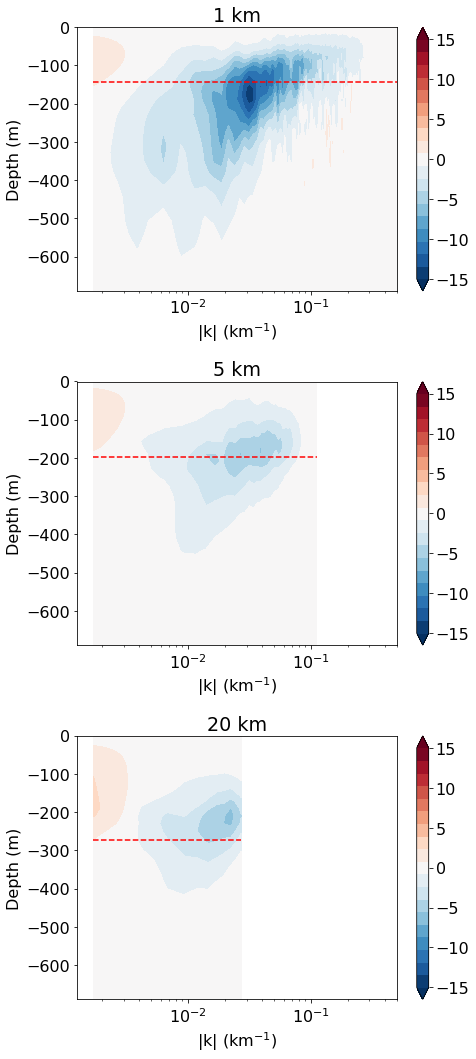

In [13]:
plt.rcParams['font.size'] = 16
plt.figure(figsize=(7,15))
n=0 
lev_exp = np.arange(-9, -2)
levs = np.power(10., lev_exp)

levs = np.linspace(-15, 15,20)

for key in res:
    kr = WCcs1D_us[key].kr*1e3
    Z = WCcs1D_us[key].Z    
    dat = WCcs1D_us[key]*1e5
    
    plt.subplot(311+n)
    plt.contourf(kr, Z, dat*kr, levs,  cmap='RdBu_r', extend='both')
    plt.title(label[key])
    plt.colorbar(ticks=[-15,-10,-5,0,5,10,15], orientation='vertical')
    
    plt.xscale('log')
    plt.xlim([1/800, 1/2])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    
    plt.ylabel('Depth (m)')
    plt.tight_layout()
    n+=1
plt.tight_layout()
plt.savefig('figures/wc_spectra_us.eps', format='eps', dpi=1000)      


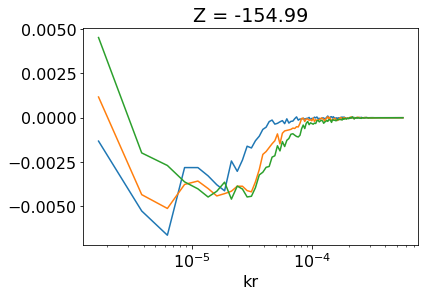

In [73]:
WCcs1D_us['01'].sel(Z=-300, method='nearest').plot()
WCcs1D_us['01'].sel(Z=-200, method='nearest').plot()
WCcs1D_us['01'].sel(Z=-150, method='nearest').plot()
plt.xscale('log')

In [63]:
# Peak horizontal scale
L_flux = {}
for key in ['01','05','20']:
    L=np.zeros(45)
    kr = WCcs1D_us[key].kr
    dk = kr[4]-kr[3]
    Z = WCcs1D_us[key].Z
    for i in range(0,45):
        L[i] = ((WCcs1D_us[key].isel(Z=i)*kr*dk).sum('kr')/
        (WCcs1D_us[key].isel(Z=i)*dk).sum('kr'))
        
    L_flux[key] = 1/L/1000

(0, 200)

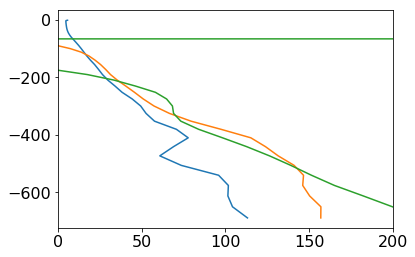

In [64]:
plt.plot(L_flux['01'], Z)
plt.plot(L_flux['05'], Z)
plt.plot(L_flux['20'], Z)
plt.xlim([0,200])

In [65]:
# Peak horizontal scale
L_flux_ds = {}
for key in ['01','05','20']:
    L=np.zeros(45)
    kr = WCcs1D_ds[key].kr
    dk = kr[4]-kr[3]
    Z = WCcs1D_ds[key].Z
    for i in range(0,45):
        L[i] = ((WCcs1D_ds[key].isel(Z=i)*kr*dk).sum('kr')/
        (WCcs1D_ds[key].isel(Z=i)*dk).sum('kr'))
        
    L_flux_ds[key] = 1/L/1000

(0, 200)

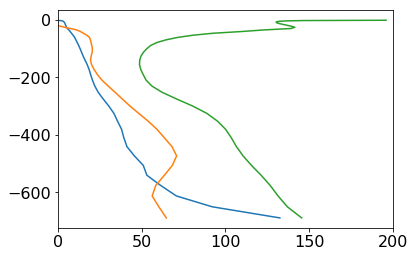

In [66]:
plt.plot(L_flux_ds['01'], Z)
plt.plot(L_flux_ds['05'], Z)
plt.plot(L_flux_ds['20'], Z)
plt.xlim([0,200])

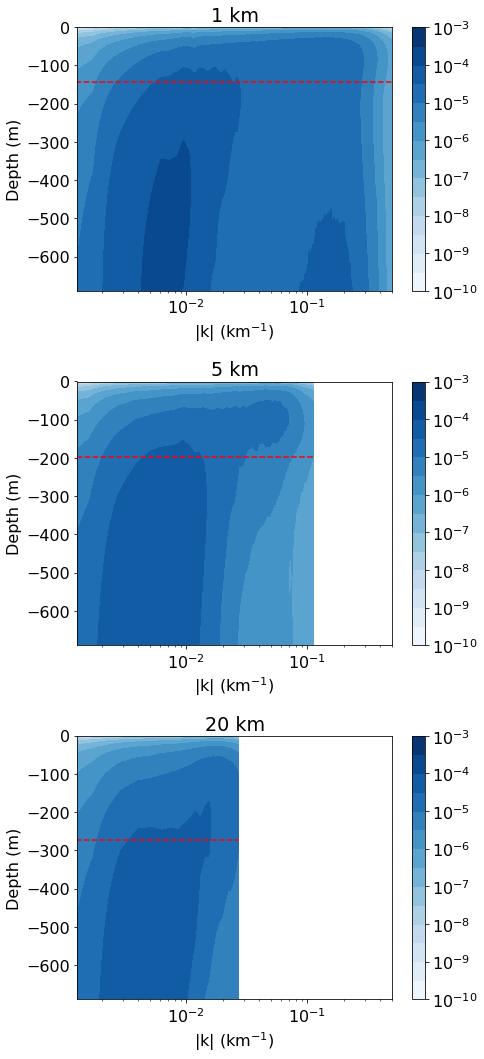

In [17]:
plt.figure(figsize=(7,15))
n=0 
lev_exp = np.linspace(-10, -3,15)
levs = np.power(10., lev_exp)


for key in res:
    kr = Wps1D_ds[key].kr*1e3
    Z = Wps1D_ds[key].Z    
    dat = Wps1D_ds[key]
    
    plt.subplot(311+n)
    plt.contourf(kr, Z, dat, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

#plt.savefig('w_spec_downstream.png', format='png', dpi=300)


In [31]:
lev_exp = np.linspace(-7, -3,10)
lev_exp

array([-7.        , -6.55555556, -6.11111111, -5.66666667, -5.22222222,
       -4.77777778, -4.33333333, -3.88888889, -3.44444444, -3.        ])

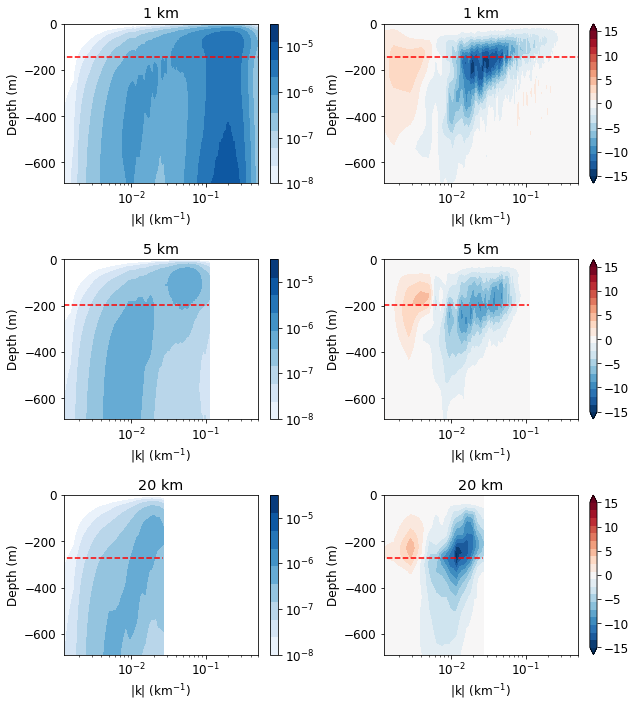

In [56]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(9,10))
n=0 
lev_exp = np.linspace(-8, -4.5,10)
levs = np.power(10., lev_exp)

lev_exp = np.arange(-9, -2)
levs2 = np.linspace(-15, 15,20)

for key in res:
    kr = Wps1D_ds[key].kr*1e3
    Z = Wps1D_ds[key].Z    
    dat = Wps1D_ds[key]
    
    plt.subplot(321+n)
    plt.contourf(kr, Z, dat*kr, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar(ticks=[1e-8,1e-7, 1e-6,1e-5], orientation='vertical')
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
    
    kr = WCcs1D_ds[key].kr*1e3
    Z = WCcs1D_ds[key].Z    
    dat = WCcs1D_ds[key]*1e5
    
    plt.subplot(321+n)
    plt.contourf(kr, Z, dat*kr, levs2,  cmap='RdBu_r', extend='both')
    plt.title(label[key])
    plt.colorbar(ticks=[-15,-10,-5,0,5,10,15], orientation='vertical')
    
    plt.xscale('log')
    plt.xlim([1/800, 1/2])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    
    plt.ylabel('Depth (m)')
    plt.tight_layout()
    n+=1
    
plt.tight_layout()

plt.savefig('w_n_wc_var_pres_spec_downstream.png', format='png', dpi=300)



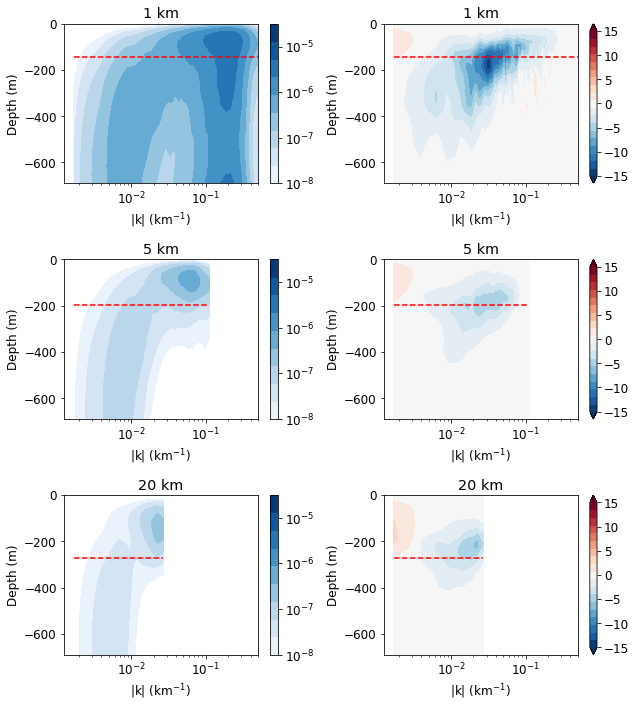

In [57]:
plt.rcParams['font.size'] = 12
plt.figure(figsize=(9,10))
n=0 
lev_exp = np.linspace(-8, -4.5,10)
levs = np.power(10., lev_exp)

lev_exp = np.arange(-9, -2)
levs2 = np.linspace(-15, 15,20)

for key in res:
    kr = Wps1D_us[key].kr*1e3
    Z = Wps1D_us[key].Z    
    dat = Wps1D_us[key]
    
    plt.subplot(321+n)
    plt.contourf(kr, Z, dat*kr, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar(ticks=[1e-8,1e-7, 1e-6,1e-5], orientation='vertical')
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
    
    kr = WCcs1D_us[key].kr*1e3
    Z = WCcs1D_us[key].Z    
    dat = WCcs1D_us[key]*1e5
    
    plt.subplot(321+n)
    plt.contourf(kr, Z, dat*kr, levs2,  cmap='RdBu_r', extend='both')
    plt.title(label[key])
    plt.colorbar(ticks=[-15,-10,-5,0,5,10,15], orientation='vertical')
    
    plt.xscale('log')
    plt.xlim([1/800, 1/2])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    
    plt.ylabel('Depth (m)')
    plt.tight_layout()
    n+=1
    
plt.tight_layout()

plt.savefig('w_n_wc_var_pres_spec_upstream.png', format='png', dpi=300)


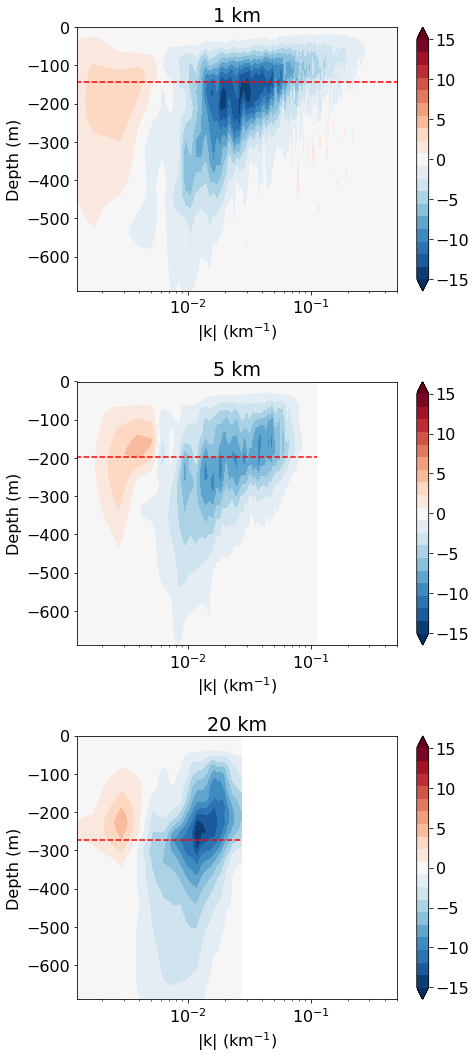

In [16]:
plt.rcParams['font.size'] = 16

plt.figure(figsize=(7,15))
n=0 
lev_exp = np.arange(-9, -2)
levs = np.power(10., lev_exp)

levs = np.linspace(-15, 15,20)

for key in res:
    kr = WCcs1D_ds[key].kr*1e3
    Z = WCcs1D_ds[key].Z    
    dat = WCcs1D_ds[key]*1e5
    
    plt.subplot(311+n)
    plt.contourf(kr, Z, dat*kr, levs,  cmap='RdBu_r', extend='both')
    plt.title(label[key])
    plt.colorbar(ticks=[-15,-10,-5,0,5,10,15], orientation='vertical')
    plt.xscale('log')
    plt.xlim([1/800, 1/2])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    
    plt.ylabel('Depth (m)')
    plt.tight_layout()
    n+=1
plt.tight_layout()
plt.savefig('figures/wc_spectra_ds.eps', format='eps', dpi=1000)      


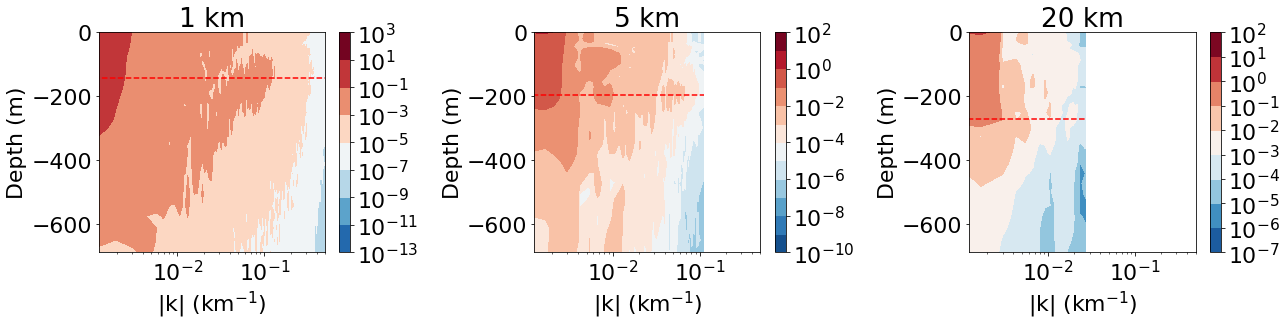

In [53]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-7, 2)
levs = np.power(10., lev_exp)

levs = np.linspace(-8, 8,10)

for key in res:
    kr = UCcs1D_ds[key].kr*1e3
    Z = UCcs1D_ds[key].Z    
    dat = 0.5*(VCcs1D_ds[key]+UCcs1D_ds[key])
    
    plt.subplot(141+n)
    plt.contourf(kr, Z, np.abs(dat*kr), norm=colors.LogNorm(),  cmap='RdBu_r')
    plt.title(label[key])
    plt.colorbar( orientation='vertical')
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    
    plt.ylabel('Depth (m)')
    plt.tight_layout()
    n+=1
plt.tight_layout()

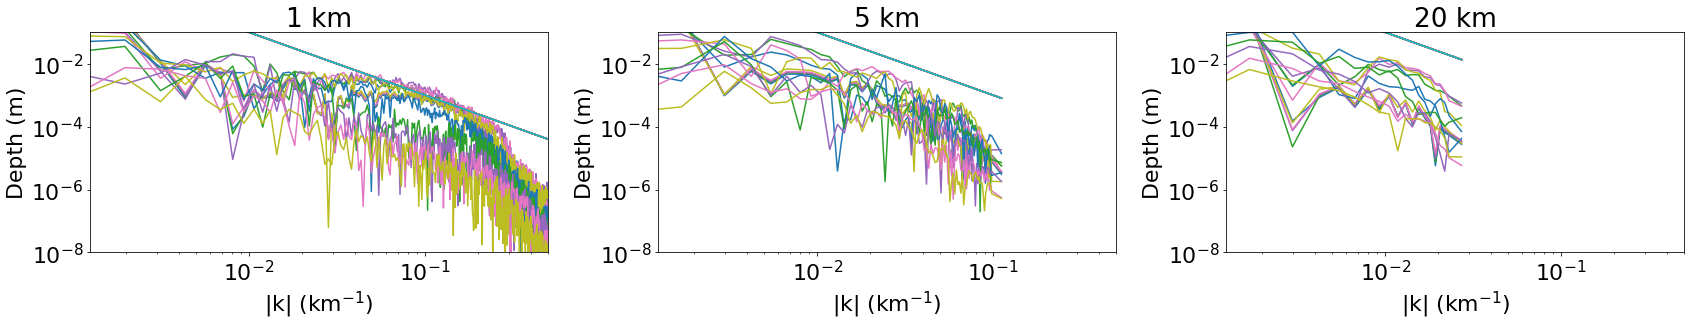

In [69]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-7, 2)
levs = np.power(10., lev_exp)

levs = np.linspace(-8, 8,10)

for key in res:
    Z = UCcs1D_ds[key].Z            
    plt.subplot(131+n)

    for i in range(0, len(Z),3):
        kr = UCcs1D_ds[key].kr*1e3
    
        dat = np.abs(0.5*(VCcs1D_ds[key]).isel(Z=i))
    
        plt.plot(kr,  (dat*kr))
        
        plt.plot(kr, 1e-5*kr**-2)
    
        plt.xscale('log')
        plt.yscale('log')
        plt.xlim([1/800, 0.5])
        plt.ylim([1e-8, 1e-1])
        
        plt.xlabel('|k| (km$^{-1}$)')
    
        plt.ylabel('Depth (m)')
    n+=1
    plt.title(label[key])
plt.tight_layout()

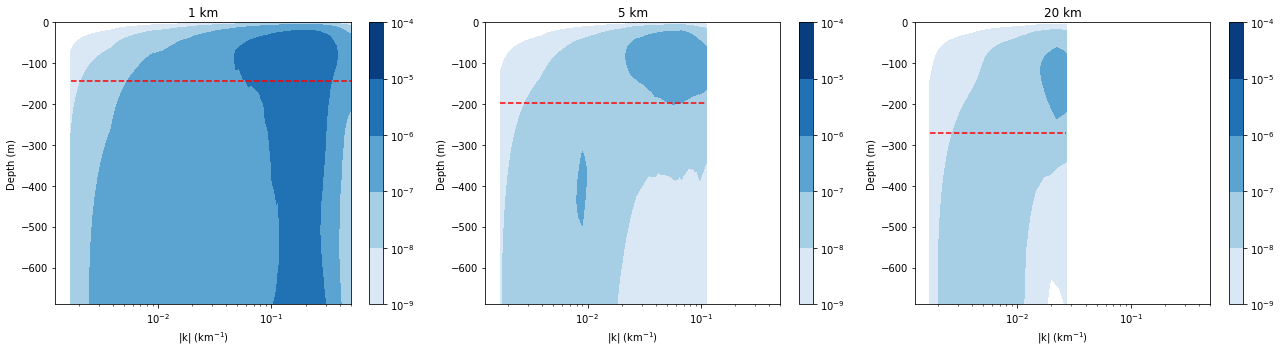

In [20]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-9, -3)
levs = np.power(10., lev_exp)

for key in res:
    kr = Wps1D_us[key].kr*1e3
    Z = Wps1D_us[key].Z    
    dat = Wps1D_us[key]
    
    plt.subplot(141+n)
    plt.contourf(kr, Z, dat*kr, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

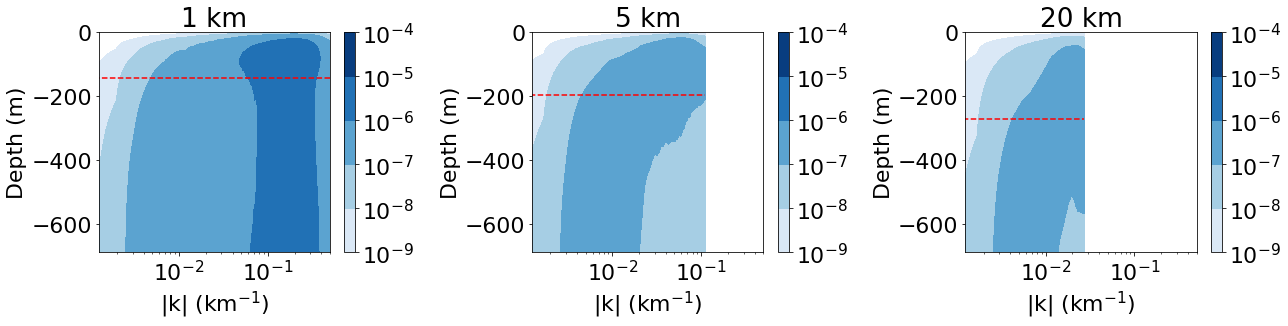

In [21]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-9, -3)
levs = np.power(10., lev_exp)

for key in res:
    kr = Wps1D_ds[key].kr*1e3
    Z = Wps1D_ds[key].Z    
    dat = Wps1D_ds[key]
    
    plt.subplot(141+n)
    plt.contourf(kr, Z, dat*kr, levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

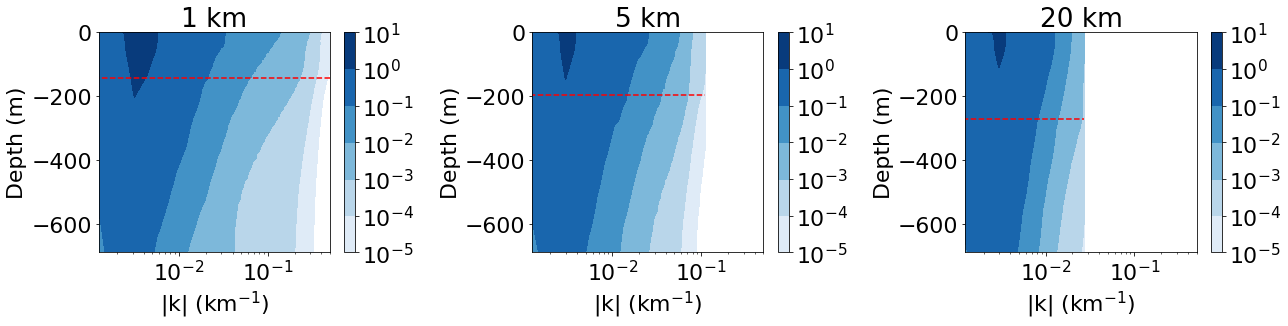

In [40]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-5, 2)
levs = np.power(10., lev_exp)

for key in res:
    kr = Ups1D_ds[key].kr*1e3
    Z = Ups1D_ds[key].Z    
    dat = 0.5*(Ups1D_ds[key] + Vps1D_ds[key])
    
    plt.subplot(141+n)
    plt.contourf(kr, Z, dat*kr,levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

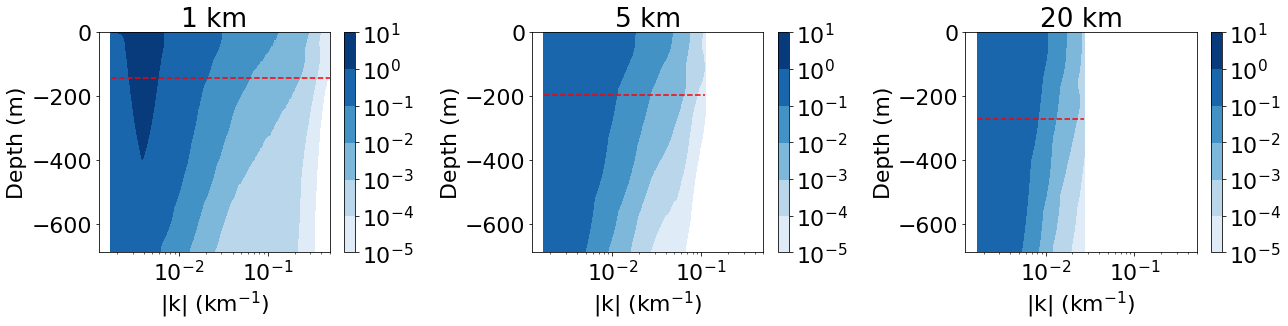

In [38]:
plt.figure(figsize=(24,5))
n=0 
lev_exp = np.arange(-5, 2)
levs = np.power(10., lev_exp)

for key in res:
    kr = Ups1D_us[key].kr*1e3
    Z = Ups1D_us[key].Z    
    dat = 0.5*(Ups1D_us[key] + Vps1D_us[key])
    
    plt.subplot(141+n)
    plt.contourf(kr, Z, dat*kr,levs, norm=colors.LogNorm(), cmap='Blues')
    plt.title(label[key])
    plt.colorbar()
    plt.xscale('log')
    plt.xlim([1/800, 0.5])
    plt.plot(kr,-kr/kr*Hmix_perc[key], '--',color='r')
    plt.xlabel('|k| (km$^{-1}$)')
    plt.ylabel('Depth (m)')
    n+=1
plt.tight_layout()

In [100]:
from matplotlib.patches import Rectangle

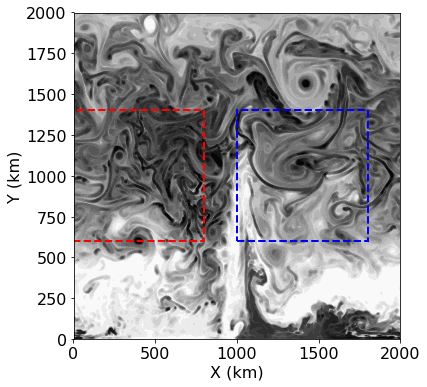

In [128]:
a = Rectangle((0,600), 800, 800, fill=False, edgecolor='r', linewidth=2, linestyle='--')
b = Rectangle((1000,600), 800, 800, fill=False, edgecolor='b', linewidth=2, linestyle='--')
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
plt.contourf(res_time['05']['data_main'].XC/1e3, res_time['05']['data_main'].YC/1e3, 
             res_time['05']['data_main'].PTRACER01.isel(time=-1).sel(Z=-250, method='nearest'), 
             cmap='gray_r', levels=np.linspace(-0,1,20))
#plt.colorbar()
#plt.contour(res_time['05']['data_main'].XC/1e3, res_time['05']['data_main'].YC/1e3, 
#             res_time['05']['data_main'].W.isel(time=-1).sel(Zl=-250, method='nearest'),
#             levels=np.array([-4,-2,2,4])/1e4
#             , cmap='RdBu_r', linewidth=1)
#res_time['05']['data_main'].W.isel(time=-1).sel(Zl=-250, method='nearest').plot.contour(
#    levels=np.array([-4,-2,2,4])/1e4, vmin=-0.0001, cmap='RdBu_r', linewidth=1)
ax.add_patch(a)
ax.add_patch(b)
ax.set_aspect('equal')
plt.title('')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.savefig('figures/c_plot.eps', format='eps', dpi=1000)      


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


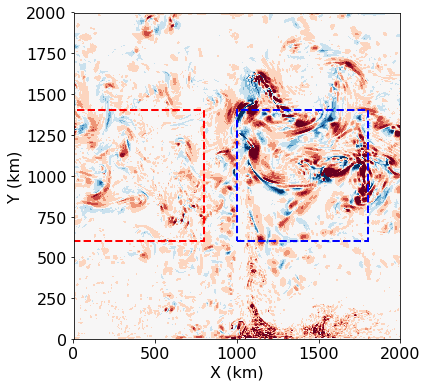

In [127]:
a = Rectangle((0,600), 800, 800, fill=False, edgecolor='r', linewidth=2, linestyle='--')
b = Rectangle((1000,600), 800, 800, fill=False, edgecolor='b', linewidth=2, linestyle='--')
plt.rcParams['font.size'] = 16

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

plt.contourf(res_time['05']['data_main'].XC/1e3, res_time['05']['data_main'].YC/1e3, 
             res_time['05']['data_main'].W.isel(time=-1).sel(Zl=-250, method='nearest'),
             levels=np.linspace(-5,5,10)/1e4
             , cmap='RdBu_r', linewidth=1, extend='both')
#res_time['05']['data_main'].W.isel(time=-1).sel(Zl=-250, method='nearest').plot.contour(
#    levels=np.array([-4,-2,2,4])/1e4, vmin=-0.0001, cmap='RdBu_r', linewidth=1)
ax.add_patch(a)
ax.add_patch(b)
ax.set_aspect('equal')
plt.title('')
plt.xlabel('X (km)')
plt.ylabel('Y (km)')
plt.savefig('figures/w_plot.eps', format='eps', dpi=1000)      


/home/dbalwada/miniconda/envs/dhruvenv/lib/python3.5/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'linewidth'
  s)


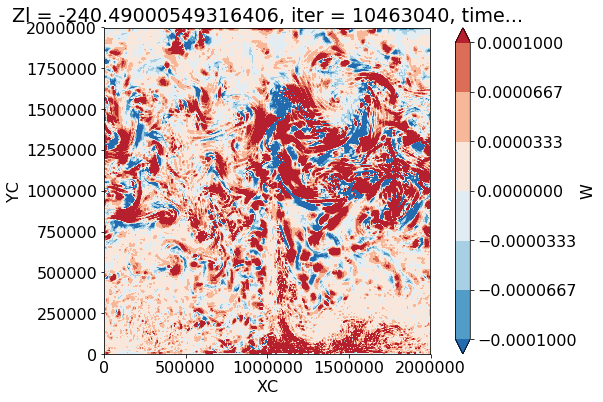

In [79]:

fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)

res_time['05']['data_main'].W.isel(time=-1).sel(Zl=-250, method='nearest').plot.contourf(
   vmin=-0.0001, cmap='RdBu_r', linewidth=1)

ax.set_aspect('equal')